In [33]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from joblib import dump, load
from time import time
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import json

## LOAD FILES

In [7]:
#LOAD MODEL

logreg = load('Logreg.joblib')

In [8]:
#LOAD DATA
dataDir = 'CleanDataFinal'

#LOAD TRAINING DATA
#features
path = os.path.join(dataDir, 'trainFeaturesFinal.csv')
train_x_pd = pd.read_csv (path, index_col = 'HHX')
train_x = train_x_pd.to_numpy()
print(train_x.shape)

#target
path = os.path.join(dataDir, 'trainTargetFinal.csv')
train_y_pd = pd.read_csv (path, index_col = 'HHX')
train_y = train_y_pd.to_numpy().flatten()
print(train_y.shape)

#LOAD TESTING DATA
#features
path = os.path.join(dataDir, 'testFeaturesFinal.csv')
test_x_pd = pd.read_csv (path, index_col = 'HHX')
test_x = test_x_pd.to_numpy()
print(test_x.shape)

#target
path = os.path.join(dataDir, 'testTargetFinal.csv')
test_y_pd = pd.read_csv (path, index_col = 'HHX')
test_y = test_y_pd.to_numpy().flatten()
print(test_y.shape)

(22222, 5290)
(22222,)
(5556, 5290)
(5556,)


## FEATURE IMPORTANCE USING PERMUTATION IMPORTANCE ALGORITHM

In [8]:
#adapted from https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

start_time = time()
result = permutation_importance(
    logreg, test_x, test_y, n_repeats=10, random_state=42, n_jobs=2, scoring='roc_auc_ovr_weighted')
elapsed_time = time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

C:\Users\Isabelle\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Elapsed time to compute the importances: 3157.976 seconds


In [60]:
#plot top feature importance
forest_importances = pd.read_csv('FeatureImportanceFullData.csv')
forest_importances.columns = ['Feature Name', 'Importance']
forest_importances = forest_importances.sort_values(by='Importance', ascending=False)

forest_importances[0:20]

,Feature Name,Importance
4006,DEPLEVEL_A_10.0,0.013338
23,GAD76_A,0.012441
25,GAD74_A,0.009197
28,GAD71_A,0.008912
39,PHSTAT_A,0.007185
26,GAD73_A,0.007075
4023,ANXLEVEL_A_10.0,0.006024
27,GAD72_A,0.005397
264,COGTYPEDFF_A_10.0,0.003487
4015,DEPFREQ_A_5,0.003161


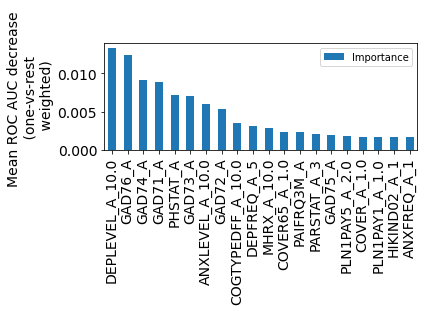

In [61]:
#plot top feature importance

#sort data
forest_importances = forest_importances.sort_values(by='Importance',ascending=False)
#grab top few features
num_features = 20
top_features = forest_importances.iloc[:num_features]

#plot top features
fig, ax = plt.subplots(figsize=(6, 4))
top_features.plot.bar(ax=ax, fontsize=14)
ax.set_ylabel("Mean ROC AUC decrease \n (one-vs-rest \n weighted)", fontsize=14)
plt.xticks(np.arange(num_features), top_features['Feature Name'])
fig.tight_layout()

#save figure
path='FullData_FeatureImportance.png'
plt.savefig(path, bbox_inches="tight")

plt.show()

## FEATURE SELECTION USING RECURSIVE FEATURE SELECTION

In [18]:
#RUN FEATURE SELECTION ON FULL DATASET
#Adapted from https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py

# Create the RFE object and compute a cross-validated score.
# Using same parameters as best Full data model 
## Wasn't seeing huge changes in scores for the different models
start_time = time()

step=20
min_features_to_select = 1  # Minimum number of features to consider
rfecv = RFECV(
    estimator=logreg,
    step=100,
    scoring="roc_auc_ovr_weighted",
    min_features_to_select=1
)

rfecv.fit(train_x, train_y)

print("Optimal number of features : %d" % rfecv.n_features_)
elapsed_time = time() - start_time
print(f"Elapsed time to select features: {elapsed_time:.3f} seconds")

Optimal number of features : 1390
Elapsed time to select features: 30861.591 seconds


In [19]:
#SAVE DATA 
resPD = pd.DataFrame(rfecv.cv_results_)

features_max = train_x.shape[1]
features_min = features_max-(len(resPD)-1)*step
features_used = np.linspace(features_max, features_min, len(resPD))
resPD['features_used'] = features_used

dataDir = 'FeatureSelection'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)

dataFile = 'FeatureSelection_cv_results.csv'
path = os.path.join(dataDir, dataFile)

resPD.to_csv(path)

selected_features = pd.DataFrame(rfecv.ranking_, columns=['Ranking'])
selected_features['FeatureName'] = train_x_pd.columns.to_list()

dataFile = 'FeatureSelection_SelectedFeatures.csv'
path = os.path.join(dataDir, dataFile)

selected_features.to_csv(path)

In [20]:
#LOAD DATA 

dataDir = 'FeatureSelection'

dataFile = 'FeatureSelection_cv_results.csv'
path = os.path.join(dataDir, dataFile)
resPD = pd.read_csv(path, index_col=0)

dataFile = 'FeatureSelection_SelectedFeatures.csv'
path = os.path.join(dataDir, dataFile)
selected_features = pd.read_csv(path, index_col=0)

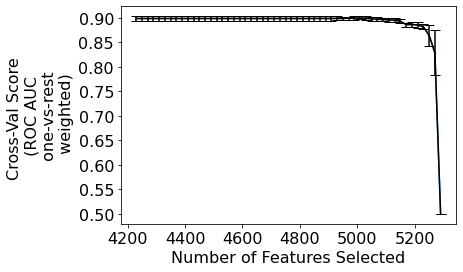

In [21]:
#GRAPH CV SCORE VS NUMBER OF FEATURES

# Plot number of features VS. cross-validation scores
plt.plot(resPD.features_used, resPD.mean_test_score)
plt.errorbar(resPD.features_used, resPD.mean_test_score, yerr=resPD.std_test_score, capsize=5, markeredgewidth=1, color='k')
plt.xlabel("Number of Features Selected", fontsize=16)
plt.ylabel("Cross-Val Score \n (ROC AUC \n one-vs-rest \n weighted)", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

#save figure
path='FeatureSelection.png'
plt.savefig(path, bbox_inches="tight")

plt.show()

In [28]:
#CHOOSE THREE SUBSETS OF FEATURES
#lowest rank for subsets = 196
features_max_rank = selected_features.Ranking.max()
#will use rank =1, 50, 100

#make lists of features for each rank 
features_01 = selected_features.FeatureName[selected_features.Ranking == 1].tolist()
print ('rank 01 number of features: ', len(features_01))
features_10 = selected_features.FeatureName[selected_features.Ranking <= 10].tolist()
print ('rank <=10 number of features: ', len(features_10))
features_50 = selected_features.FeatureName[selected_features.Ranking <= 50].tolist()
print ('rank <=100 number of features: ', len(features_50))

rank 01 number of features:  1390
rank <=10 number of features:  2290
rank <=100 number of features:  5290


In [49]:
#MAKE FINAL MODELS
t0 = time()

test_scores = []
trained_models = []
feature_lists = [features_01, features_10]

#for saving results
dataDir = 'ReducedFeatures'
if not os.path.exists(dataDir):
    os.mkdir(dataDir)
    
trained_model_paths = []
for fl in feature_lists:
    datafile = 'logreg_' + str(len(fl)) + '_features.joblib'
    path = os.path.join(dataDir, datafile)
    trained_model_paths.append(path)
    
i = 1
for fl, path in zip(feature_lists, trained_model_paths):
    #create RFC object
    logreg_rf =  LogisticRegression(penalty="l2", solver='newton-cg')
    #select features
    train_x_subset = train_x_pd.loc[:, fl].to_numpy()
    #train model
    logreg_rf.fit(train_x_subset, train_y)
    #save model and put in list
    dump(logreg_rf, path)
    trained_models.append(logreg_rf)
    #test model on subset of features
    test_x_subset = test_x_pd.loc[:, fl].to_numpy()
    roc_auc_test = roc_auc_score(test_y, logreg_rf.predict_proba(test_x_subset), multi_class='ovr', average='weighted')
    test_scores.append(roc_auc_test)
    #give update
    print('done with model: ' + str(i))
    i = i+1
    
#save scores
idx = [str(len(features_01))+'_FEATURES', str(len(features_10))+'_FEATURES']
test_scores_pd = pd.DataFrame(test_scores, index=idx, columns=['ROC_AUC_OVR_WEIGHTED'])
filepath = 'TestScores.csv'
path = os.path.join(dataDir, filepath)
test_scores_pd.to_csv(path)

print("done in %0.3fs" % (time() - t0))

done with model: 1
done with model: 2
done in 755.788s


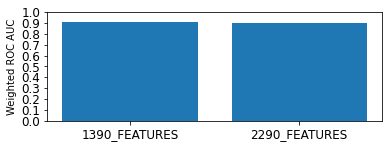

In [53]:

#PLOT CV 
plt.figure(figsize = (6, 2))
x = np.arange(2)
plt.bar(x, test_scores)
plt.xticks(x, test_scores_pd.index.to_list(), fontsize=12)
plt.yticks(np.arange(0, 1.1, step=0.1), fontsize=12)
plt.ylabel("Weighted ROC AUC")
plt.show()